# Importing Libraries <a name='libraries'></a>

In [44]:
import pandas as pd
import numpy as np
# from isodate import parse_duration
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
import nltk
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Youtube Data Fetching

In [45]:
# Utils.py

In [46]:
import pandas as pd
class Utils:

    # Function to get video details
    def get_video_details(youtube, video_id):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_id
        )
        response = request.execute()

        if not response['items']:
            return None

        video_info = response['items'][0]
        snippet = video_info['snippet']
        statistics = video_info['statistics']
        content_details = video_info['contentDetails']
        title = snippet.get('title', "")  # Extract title
        description = snippet.get('description', "")
        view_count = statistics.get('viewCount', 0)
        like_count = statistics.get('likeCount', 0)
        dislike_count = statistics.get('dislikeCount', 0)
        comment_count = statistics.get('commentCount', 0)
        duration = content_details.get('duration', "")
        favorite_count = statistics.get('favoriteCount', 0)

        return {
            "video_id": video_id,
            "title": title,
            "description": description,
            "view_count": view_count,
            "like_count": like_count,
            "dislike_count": dislike_count,
            "comment_count": comment_count,
            "duration": duration,
            "favorite_count": favorite_count
        }

    # Function to get comments
    def get_comments(youtube, video_id):
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            order="relevance"  # Order comments by relevance (most popular)
        )
        response = request.execute()

        comments = []
        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        return comments

    # Function to save results to a CSV file
    def save_results_to_csv(results, start_video_id, end_video_id):
        if results:
            output_filename = f'./files/output_files/youtube_video_data_{start_video_id}_to_{end_video_id}.csv'
            results_df = pd.DataFrame(results)
            results_df.to_csv(output_filename, index=False)
            print(f"Saved results to {output_filename}")

In [47]:
# Data_extractor.py

In [48]:
# import pandas as pd
# import googleapiclient.discovery
# from googleapiclient.discovery import build
# from Utils import Utils as utils
# from dotenv import load_dotenv
# import os

# # Load environment variables from .env file
# load_dotenv()

# # Create YouTube resource object
# youtube = build('youtube',
#                 'v3',
#                 developerKey=os.getenv("API_KEY"))

# # Load the CSV file with status
# file_path = './files'
# csv_file_path = file_path + '/youtube_video_links.csv'
# df = pd.read_csv(csv_file_path)

# print("File Size ", df.size)

# # Check if 'status' column exists
# if 'status' not in df.columns:
#     # Add a status column and initialize with 'Not Fetched'
#     df['status'] = 'Not Fetched'

#     # Save the updated CSV file
#     df.to_csv(csv_file_path, index=False)

# # Initialize or get the start index
# start_index = 0
# # if 'd1' in df.columns and pd.notna(df.at[0, 'd1']) and df.at[0, 'd1'] != 0:
# #     start_index = int(df.at[0, 'd1'])

# print(f"Starting from index {start_index}")

# # Initialize start row number
# start_row_number = start_index  # Initialize start_row_number here

# # List to store results
# results = []

# # Get the start video ID for the output filename
# start_video_id = None
# comments = None

# # Process each video ID from the start index
# for idx in range(start_index, len(df)):
#     print(f"Processing video {idx}")
#     is_comment_disabled = False
#     # reset comment for each iteration
#     comments = ''

#     row = df.iloc[idx]
#     if row['status'] == 'Not Fetched':
#         if start_video_id is None:
#             start_video_id = row['youtubeId']

#         video_id = row['youtubeId']
#         try:
#             video_details = utils.get_video_details(youtube, video_id)
#             comments = utils.get_comments(youtube, video_id)
#         except googleapiclient.errors.HttpError as e:
#             # print(e)
#             if e.resp.status == 404:
#                 print(f"Video not found: {video_id}")
#                 df.at[idx, 'status'] = 'Video Not Found'
#                 continue
#             elif e.resp.status == 403:
#                 error_reason = e.content.decode().lower()
#                 if "exceeded" in error_reason:
#                     print(f"Quota exceeded. Stopping the execution.")
#                     break  # Stop the execution if quota is exceeded
#                 elif "commentsdisabled" in error_reason:
#                     print(f"Error fetching data for video {video_id}: commentsdisabled")
#                     is_comment_disabled = True
#                     # continue
#             elif e.resp.status in [500, 503]:
#                 print(f"Temporary server error for video {video_id}")
#                 break
#             else:
#                 print(f"Error fetching data for video {video_id}")
#                 continue

#         if video_details:
#             video_details['comments'] = comments
#             results.append(video_details)
#             df.at[idx, 'status'] = 'Fetched, Comment Disabled' if is_comment_disabled else 'Fetched'

#         # Periodically save results and update CSV
#         if len(results) >= 5000:  # Save every 1000 records
#             end_video_id = video_details['video_id']
#             utils.save_results_to_csv(results, start_row_number, idx)
#             results = []  # Clear results after saving
#             start_video_id = None  # Reset start_video_id for the next batch
#             start_row_number = idx + 1  # Update start row number

#             # Update the d1 column with the current index
#             df.at[0, 'd1'] = idx
#             df.to_csv(csv_file_path, index=False)

# # print("results ", results)
# # Save any remaining results
# if results:
#     end_video_id = results[-1]['video_id']
#     utils.save_results_to_csv(results, start_row_number, idx)
#     # Update the d1 column with the current index
#     df.at[0, 'd1'] = idx
#     df.to_csv(csv_file_path, index=False)
# print(df.head())

# print("Processing complete.")


# Analysis of Video links

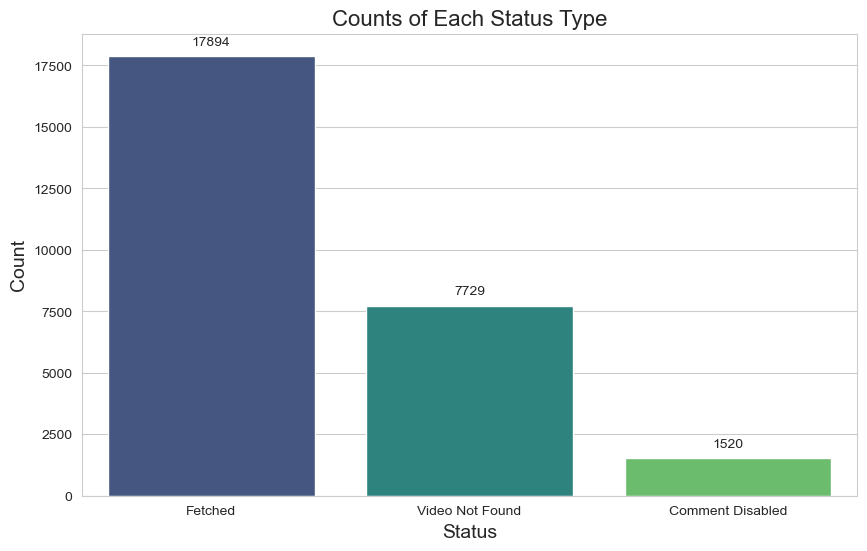

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the CSV file
df = pd.read_csv('files/youtube_video_links.csv')

# Count the occurrences of each status type
fetched_count = df['status'].str.contains('Fetched').sum()
video_not_found_count = df['status'].str.contains('Video Not Found').sum()
comment_disabled_count = df['status'].str.contains('Comment Disabled').sum()

# Create a DataFrame for visualization
status_counts = pd.DataFrame({
    'Status': ['Fetched', 'Video Not Found', 'Comment Disabled'],
    'Count': [fetched_count, video_not_found_count, comment_disabled_count]
})

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Status', y='Count', data=status_counts, palette='viridis')

# Add labels to the plot
bar_plot.set_xlabel('Status', fontsize=14)
bar_plot.set_ylabel('Count', fontsize=14)
bar_plot.set_title('Counts of Each Status Type', fontsize=16)

# Annotate the bars with the counts
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 10),
                      textcoords = 'offset points')

# Show the plot
plt.show()


# Data Pre-processing <a name='pre_process'></a>

In [51]:
df=pd.read_csv('files/output_files/youtube_video_data_0_to_14914.csv')

In [52]:
df.head()

,video_id,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
0,PrPSuTEISpg,Dust Devil - The Final Cut Richard Stanley,"Finally, from Richard Stanley, the director of...",81912,188,0,0,PT2M21S,0,[]
1,t_WinzX9JNM,Korean Horror - Phone 2002 (Trailer),After writing a series of articles about pedop...,60293,109,0,16,PT1M15S,0,['It&#39;s on Netflix if you have that. I saw ...
2,NkLrAcjQBp8,J.C.V.D - The Order [2001] - Trailer,THE ORDER - Courtesy: © Copyright by 777 Films...,19682,20,0,2,PT1M56S,0,"['Awesome movie!', 'the best movie: van damme ..."
3,JY3u7bB7dZk,Serenity (2005) Trailer 1080p HD,This is the trailer for the 2005 film Serenity...,2364312,3667,0,694,PT2M22S,0,['How has no millionaire gone and said &#39;He...
4,qHr8OzaloLM,The End of Suburbia promo trailer,"""We're literally stuck up a cul-de-sac in a ce...",225631,450,0,149,PT2M47S,0,['This is the very best movie out there on Pea...


In [53]:
df.drop('dislike_count', axis=1, inplace=True)

In [54]:
# df.drop('video_id', axis=1, inplace=True)

In [55]:
# Get unique values of the 'favorite_count' column
unique_favorite_counts = df['favorite_count'].unique()

# Print the unique values
print(unique_favorite_counts)

[0]


In [56]:
# All favorite count column has 0 , so we are dropping the column alltogether.

In [57]:
df.drop('video_id', axis=1, inplace=True)

In [58]:
df.isna().sum()

title               0
description        81
view_count          0
like_count          0
comment_count       0
duration            0
favorite_count      0
comments          265
dtype: int64

In [59]:
df['duration'] = pd.to_timedelta(df['duration'])

In [60]:
#Converting float data types to int
placeholder_value = -1  # Choose an appropriate placeholder value
df['comment_count'].fillna(placeholder_value, inplace=True)
df['like_count'].fillna(placeholder_value, inplace=True)
df['view_count'].fillna(placeholder_value, inplace=True)

df['comment_count']=df['comment_count'].round().astype(int)
df['like_count']=df['like_count'].round().astype(int)

C:\Users\umesh\AppData\Local\Temp\ipykernel_13224\140956340.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['comment_count'].fillna(placeholder_value, inplace=True)
C:\Users\umesh\AppData\Local\Temp\ipykernel_13224\140956340.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [61]:
df.head()

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments
0,Dust Devil - The Final Cut Richard Stanley,"Finally, from Richard Stanley, the director of...",81912,188,0,0 days 00:02:21,0,[]
1,Korean Horror - Phone 2002 (Trailer),After writing a series of articles about pedop...,60293,109,16,0 days 00:01:15,0,['It&#39;s on Netflix if you have that. I saw ...
2,J.C.V.D - The Order [2001] - Trailer,THE ORDER - Courtesy: © Copyright by 777 Films...,19682,20,2,0 days 00:01:56,0,"['Awesome movie!', 'the best movie: van damme ..."
3,Serenity (2005) Trailer 1080p HD,This is the trailer for the 2005 film Serenity...,2364312,3667,694,0 days 00:02:22,0,['How has no millionaire gone and said &#39;He...
4,The End of Suburbia promo trailer,"""We're literally stuck up a cul-de-sac in a ce...",225631,450,149,0 days 00:02:47,0,['This is the very best movie out there on Pea...


In [62]:
df['comments']=df['comments'].fillna("")
df['description']=df['description'].fillna("")

In [63]:
df.isna().sum()

title             0
description       0
view_count        0
like_count        0
comment_count     0
duration          0
favorite_count    0
comments          0
dtype: int64

In [64]:
df.shape

(3471, 8)

In [65]:
df.columns

Index(['title', 'description', 'view_count', 'like_count', 'comment_count',
       'duration', 'favorite_count', 'comments'],
      dtype='object')

## List of the top-10 videos based on total views: <a name='top_10Videos'></a>

In [66]:
# top_10_videos = df.nlargest(10, 'viewcount')['title']

df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
df_sorted = df.sort_values(by='view_count',ascending=False)


top_10_videos = df_sorted.head(10)



In [67]:
print(top_10_videos[['title', 'view_count']])

                                                  title  view_count
3169                                     Growth Trailer    71939300
2669   "Paranormal Activity" - Official Trailer [HQ HD]    33731881
3245  THE HUMAN CENTIPEDE (2010) | Hollywood.com Mov...    33715605
2907            Aaja Nachle - Title Song - High Quality    30817519
3457                             Inside The Twin Towers    27299979
459                               Scary Movie 4 Trailer    21781592
2831             50 Cent (Before I Self Destruct) Movie    17048583
1948                      SLUMDOG MILLIONAIRE - Trailer    15064164
3088                   Killer Bean 2.1 - The Party (HD)    14660059
3044           "Shutter Island" - Official Trailer [HD]    14529970


## List of the bottom-10 videos based on total views: <a name='bottom_10Videos'></a>

In [68]:

df_sorted = df[df.view_count > 0].sort_values(by='view_count')
bottom_10_videos = df_sorted.head(10)

In [69]:
print(bottom_10_videos[['title', 'view_count']])

                                                  title  view_count
578   Prova d'orchestra Orchestra Rehearsal 1978  Di...         230
1655                          The Window (1949)  costas         479
627             #TheYearWas 1940 - ANGELS OVER BROADWAY         789
2347       Phil Silvers in A Lady Takes A Chance (1943)         972
2924                     Jim Beaver in Twogether (1994)         981
2203         Tales from the North: Going to Kansas City         995
3163                            Žižek! (2007) — Trailer        1003
3076                   Pudana - Last of the Line - VOST        1072
294   Ernest Irving: Main & End Title music from "A ...        1085
420   "Nan Guo Zai Jian, Nan Guo" Hou Hsiao Hsien, 1996        1118


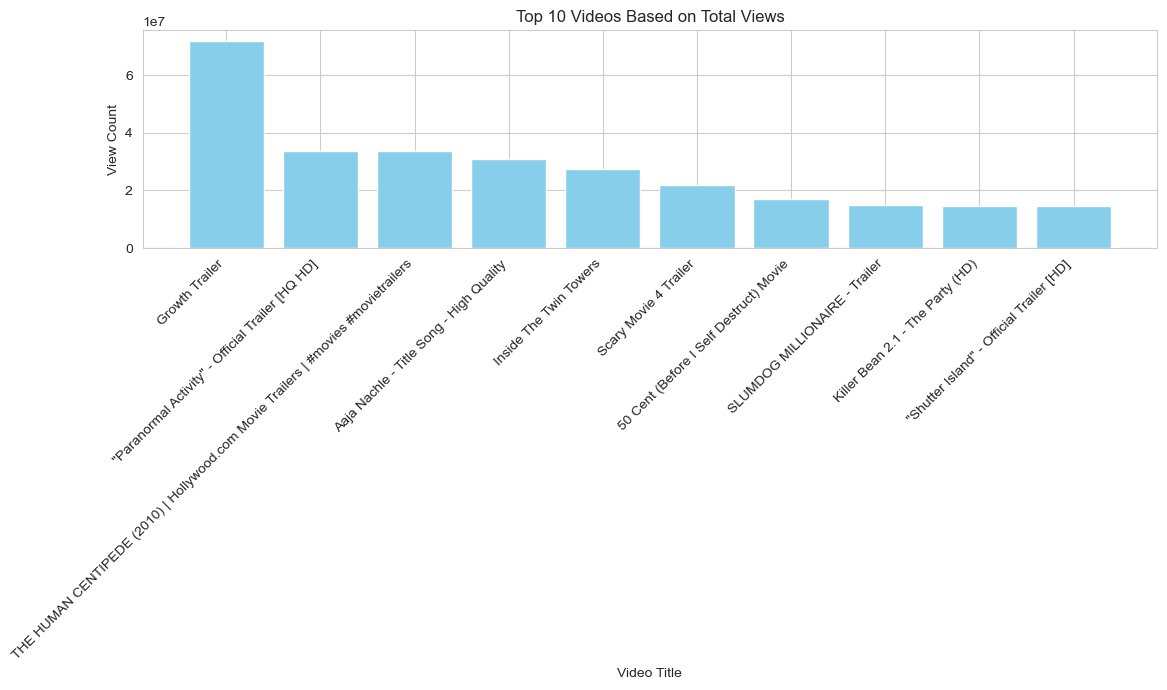

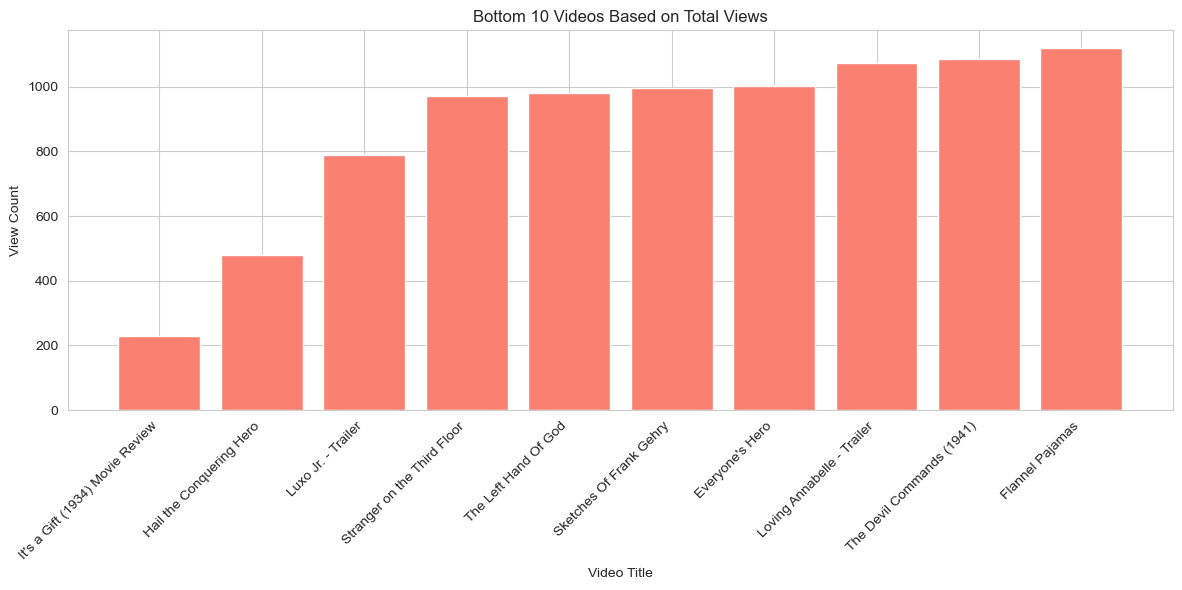

In [70]:
# Sort the DataFrame by view counts in descending order for top 10 videos
df_top = df.nlargest(10, 'view_count')

# Sort the DataFrame by view counts in ascending order for bottom 10 videos
df_bottom = df.nsmallest(10, 'view_count')

# Create a bar chart for the top 10 videos
plt.figure(figsize=(12, 7))
plt.bar(df_top['title'], top_10_videos['view_count'], color='skyblue')
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Top 10 Videos Based on Total Views')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a bar chart for the bottom 10 videos
plt.figure(figsize=(12, 6))
plt.bar(df_bottom['title'],bottom_10_videos ['view_count'], color='salmon')
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Bottom 10 Videos Based on Total Views')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## The most liked video:<a name='most_liked_video'></a>

In [71]:
df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')

df_sorted_likes = df.sort_values(by='like_count', ascending=False)

most_liked_video = df_sorted_likes.head(1)


In [72]:
print(most_liked_video[['title', 'like_count']])

                       title  like_count
3457  Inside The Twin Towers      148627


## The least liked video:<a name='least_liked_video'></a>

In [73]:
# # Filter out rows with zero 'Like Count'
# non_zero_likes = df[df['Like Count'] > 0]

df_sorted_likes = df[df.like_count > 0].sort_values(by='like_count')
least_liked_video = df_sorted_likes.head(5)


In [74]:
print(least_liked_video[['title', 'like_count']])

                                             title  like_count
2037                                  Ober Trailer           1
1655                     The Window (1949)  costas           1
1692                                World Moves On           1
992          Ni pour ni contre [Bien au contraire]           1
2347  Phil Silvers in A Lady Takes A Chance (1943)           2


## The Video with Highest Duration:<a name='highest_duration_video'></a>

In [75]:
# video_with_highest_duration = df[df['Duration'] == df['Duration'].max()]
# video_with_highest_duration['title']

# Convert the duration to a timedelta format
df['duration'] = pd.to_timedelta(df['duration'])

df_sorted_duration = df.sort_values(by='duration', ascending=False)
video_highest_duration = df_sorted_duration.head(1)

print(video_highest_duration[['title', 'duration']])

               title        duration
2424  Salaam Namaste 0 days 02:38:21


## Sentiment Analysis:<a name='sentiment_analysis'></a>

In [76]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   --- ------------------------------------ 10.2/126.0 kB ? eta -:--:--
   -------------------------- ------------- 81.9/126.0 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 126.0/126.0 kB 1.5 MB/s eta 0:00:00


In [77]:
def preprocess_text(text):
    """
    Preprocesses the text by converting to lowercase, tokenizing, and removing stopwords.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in nltk.corpus.stopwords.words('english')]

    processed_text = ' '.join(tokens)
    return processed_text

In [78]:
df1 = df.head()

In [79]:
def analyze_sentiment(text):
    """
    Analyzes the sentiment of the given text using VADER (Valence Aware Dictionary and sEntiment Reasoner).

    Args:
        text (str): The text for which sentiment analysis is to be performed.

    Returns:
        tuple: A tuple containing the sentiment label and the sentiment score.
    """
    analyzer = SentimentIntensityAnalyzer()
    if text == "":
        return "NO", 0
    preprocessed_text = preprocess_text(text)
    sentiment_scores = analyzer.polarity_scores(preprocessed_text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return "Positive", compound_score
    elif compound_score <= -0.05:
        return "Negative", compound_score
    else:
        return "Neutral", compound_score

# Initialize lists for storing sentiment scores and labels
sentiment_score = []
scores = []

# Iterate through the comments and perform sentiment analysis
for count, comment in enumerate(df['comments']):
    sentiment, score = analyze_sentiment(comment)
    sentiment_score.append(sentiment)
    scores.append(score)

# Add the sentiment analysis results to the DataFrame
df['Sentiment'] = sentiment_score
df['Scores'] = scores


In [80]:
# Save the updated DataFrame to a CSV file
df.to_csv('youtube_data_with_sentiment.csv', index=False)

In [81]:
df.head()

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments,Sentiment,Scores
0,Dust Devil - The Final Cut Richard Stanley,"Finally, from Richard Stanley, the director of...",81912,188,0,0 days 00:02:21,0,[],Neutral,0.0000
1,Korean Horror - Phone 2002 (Trailer),After writing a series of articles about pedop...,60293,109,16,0 days 00:01:15,0,['It&#39;s on Netflix if you have that. I saw ...,Positive,0.8658
2,J.C.V.D - The Order [2001] - Trailer,THE ORDER - Courtesy: © Copyright by 777 Films...,19682,20,2,0 days 00:01:56,0,"['Awesome movie!', 'the best movie: van damme ...",Positive,0.8555
3,Serenity (2005) Trailer 1080p HD,This is the trailer for the 2005 film Serenity...,2364312,3667,694,0 days 00:02:22,0,['How has no millionaire gone and said &#39;He...,Positive,0.9998
4,The End of Suburbia promo trailer,"""We're literally stuck up a cul-de-sac in a ce...",225631,450,149,0 days 00:02:47,0,['This is the very best movie out there on Pea...,Positive,0.9964


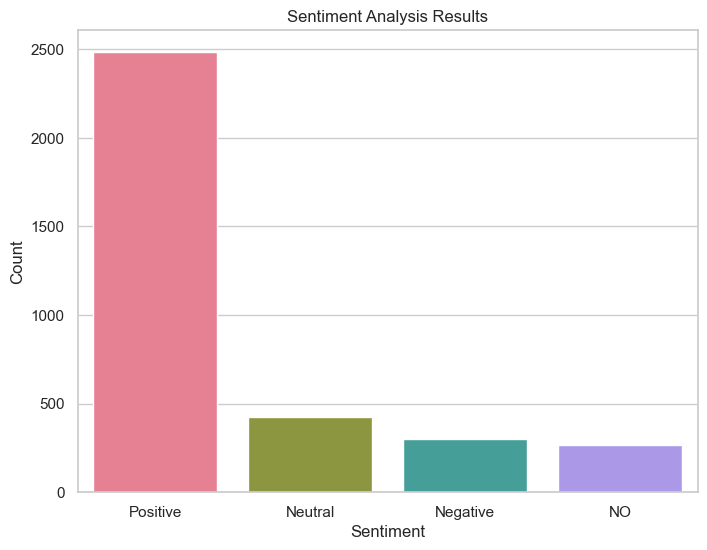

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x='Sentiment', data=df, palette=sns.color_palette("husl", df['Sentiment'].nunique()), order=df['Sentiment'].value_counts().index)
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

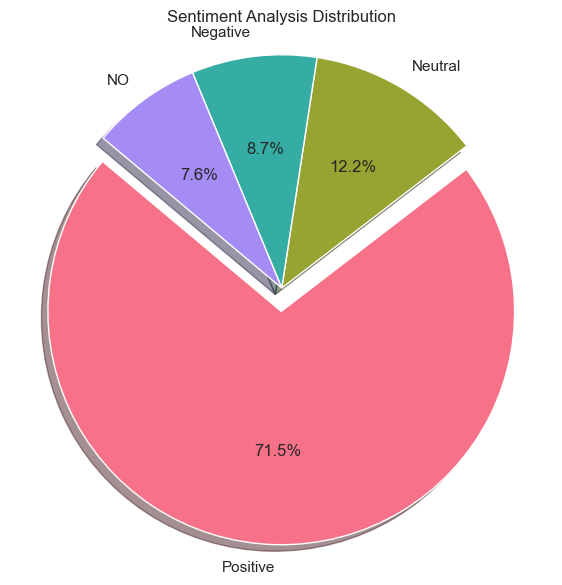

In [90]:
# Create a pie chart using Matplotlib
labels = df['Sentiment'].value_counts().index
sizes = df['Sentiment'].value_counts().values
colors = sns.color_palette("husl", len(labels))  # Generate a color palette based on the number of unique sentiments
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]  # explode the 1st slice

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, explode=explode)
plt.axis('equal')
plt.title('Sentiment Analysis Distribution')
plt.show()

In [83]:
df[df['Sentiment']=="Negative"]

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments,Sentiment,Scores
23,PRIME CUT - TEASER TRAILER,My rough cut for a teaser trailer I'm assembli...,60680,110,1,0 days 00:02:09,0,['I like it but schifrins killer music is sadl...,Negative,-0.7783
27,Acacia Trailer,Beguiling Korean teaser trailer for Park Ki-hy...,106663,117,30,0 days 00:01:17,0,['I remember watching this as a todd thinking ...,Negative,-0.9254
33,Pusher 2 - Trailer,,203660,427,48,0 days 00:01:31,0,"['Best of the trilogy', 'grandiose Filmreihe …...",Negative,-0.9837
43,Toolbox Murders (2004) Trailer,Toolbox Murders (2004) Trailer\nhttp://www.fac...,143641,424,61,0 days 00:01:29,0,['This movie has huge in México throw back the...,Negative,-0.9918
52,trailer strings.wmv,Titulo: Cuerdas\nTítulo Original: Strings\nDir...,10798,12,1,0 days 00:01:37,0,"['... i got nervous, u know']",Negative,-0.2732
...,...,...,...,...,...,...,...,...,...,...
3451,South park imaginationland,Imaginationland gets attacked by terrorists,175100,261,125,0 days 00:03:51,0,['I literly screamed &quot;NO CHARLIE BROWN!&q...,Negative,-0.1459
3452,Marie and Bruce (2004) movie trailer,Marie Bruce\nDirector: Tom Cairns\nWriters: Wa...,10586,33,1,0 days 00:02:01,0,['God that looks terrible and not even funny...'],Negative,-0.0516
3457,Inside The Twin Towers,"Aired on September 3, 2006 on The Discovery Ch...",27299979,148627,47985,0 days 01:31:49,0,['My father was supposed to be on the flight t...,Negative,-0.9955
3460,"""Leslie, My Name is Evil"" - Official Trailer [HD]","Dark, lustful and deadly love...\r\nIn theater...",323437,713,171,0 days 00:01:40,0,['I love the theme song of this movie. Look it...,Negative,-0.6698


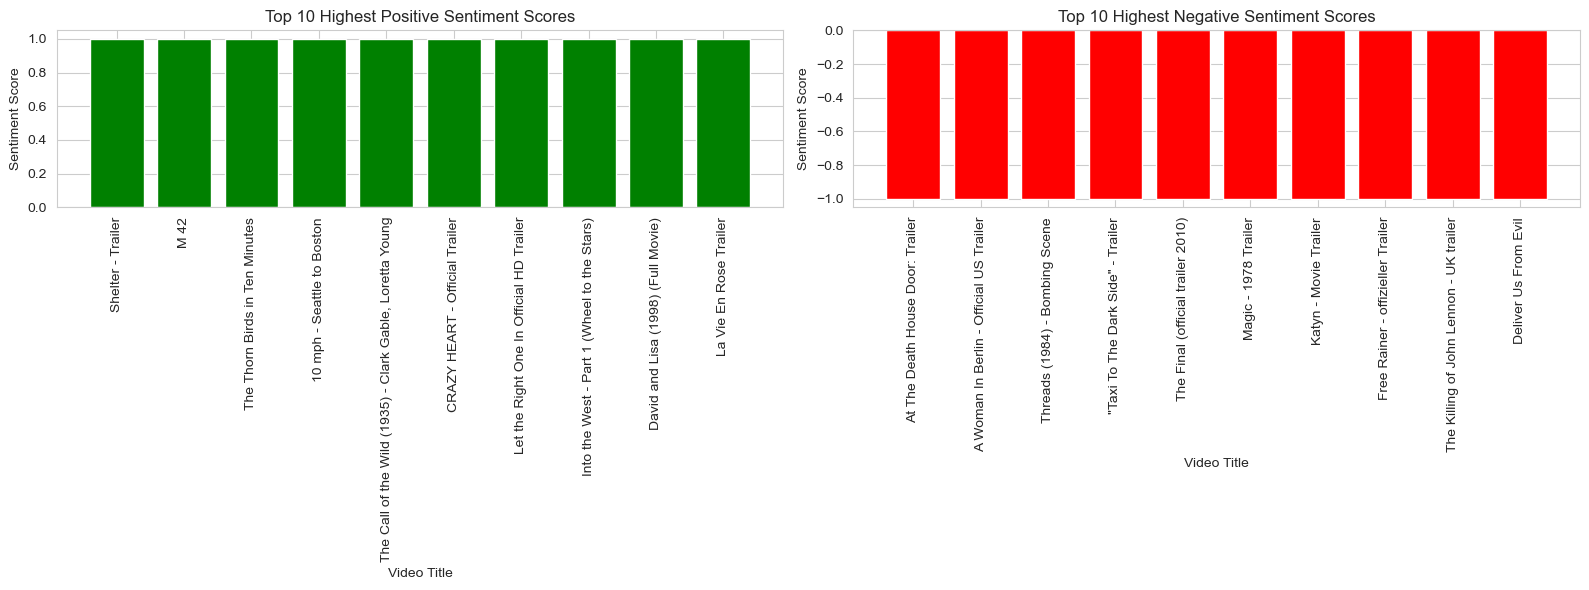

In [84]:
filtered_df = df[df['Scores'] != 0.0000]

top_10_positive_sentiment = filtered_df.sort_values(by='Scores', ascending=False).head(10)


bottom_10_positive_sentiment = filtered_df.sort_values(by='Scores', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.bar(top_10_positive_sentiment['title'], top_10_positive_sentiment['Scores'], color='green')
ax1.set_title('Top 10 Highest Positive Sentiment Scores')
ax1.set_xlabel('Video Title')
ax1.set_ylabel('Sentiment Score')
ax1.tick_params(axis='x', rotation=90)

ax2.bar(bottom_10_positive_sentiment['title'], bottom_10_positive_sentiment['Scores'], color='red')
ax2.set_title('Top 10 Highest Negative Sentiment Scores')
ax2.set_xlabel('Video Title')
ax2.set_ylabel('Sentiment Score')
ax2.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()


# Conclusion

# Future Improvements and Recommendations